In [8]:
# %% [markdown]
# # Part 2: Movie Ratings Prediction with sklearn’s NMF
#
# **Files:**
# - **train.csv:** Contains movie ratings training data with columns: uID, mID, rating
# - **test.csv:** Contains movie ratings test data with columns: uID, mID, rating
# - **movies.csv:** Contains movie details (mID, title, year, etc.)
# - **users.csv:** Contains user information (uID, gender, age, occupation, zip)
#
# **Objective:**
# - Build a recommender system using matrix factorization (NMF) to predict ratings.
# - Create a user-item matrix from the training data.
# - Use sklearn’s NMF to predict missing ratings for the test set pairs.
# - Compute RMSE on the test ratings.
# - Compare against a simple baseline (global mean).
# - Discuss limitations and potential improvements.


# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [9]:
# %% [markdown]
# ## 1. Load the Movie Ratings Data and Build User-Item Matrix

# %% [code]
# Load the four files (adjust paths as necessary)
ratings_train = pd.read_csv('./data/movie_ratings/train.csv')   # Columns: uID, mID, rating
ratings_test  = pd.read_csv('./data/movie_ratings/test.csv')      # Columns: uID, mID, rating
movies = pd.read_csv('./data/movie_ratings/movies.csv')           # Contains mID, title, year, etc.
users  = pd.read_csv('./data/movie_ratings/users.csv')            # Contains uID, gender, age, occupation, zip

print("Ratings Train shape:", ratings_train.shape)
print("Ratings Test shape:", ratings_test.shape)
print("Movies shape:", movies.shape)
print("Users shape:", users.shape)

# Create a user-item matrix from the training ratings.
# Rows: unique uID; Columns: unique mID; Values: rating
user_item_train = ratings_train.pivot(index='uID', columns='mID', values='rating')
print("User-Item Matrix shape:", user_item_train.shape)

Ratings Train shape: (700146, 3)
Ratings Test shape: (300063, 3)
Movies shape: (3883, 21)
Users shape: (6040, 5)
User-Item Matrix shape: (6040, 3664)


n_components = 10 -> RMSE: 2.9118
n_components = 20 -> RMSE: 2.8615
n_components = 30 -> RMSE: 2.8651
n_components = 40 -> RMSE: 2.8836

NMF RMSE Results for Movie Ratings:
   n_components      RMSE
0            10  2.911773
1            20  2.861480
2            30  2.865101
3            40  2.883632


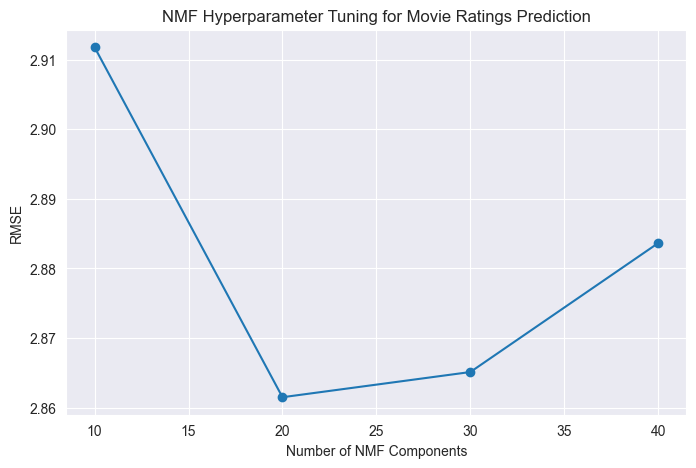

In [10]:
# %% [markdown]
# ## 2. Prepare the Training Matrix for NMF
#
# Fill missing ratings with 0. (Note: 0 is not an actual rating but is used for factorization.)

# %% [code]
train_matrix = user_item_train.fillna(0)

# %% [markdown]
# ## 3. Apply NMF and Predict Ratings on the Test Set
#
# We experiment with different numbers of latent factors (n_components).
# For each setting, we factorize the training matrix, reconstruct it, and then for each (uID, mID) in the test set, we predict the rating.
# Finally, we compute the RMSE.

# %% [code]
from sklearn.metrics import mean_squared_error

n_components_list_ratings = [10, 20, 30, 40]
nmf_results_ratings = []

for n in n_components_list_ratings:
    nmf_model = NMF(n_components=n, init='nndsvda', random_state=42, max_iter=300)
    W = nmf_model.fit_transform(train_matrix)
    H = nmf_model.components_

    reconstructed = np.dot(W, H)

    test_actual = []
    test_pred = []
    for index, row in ratings_test.iterrows():
        user = row['uID']
        movie = row['mID']
        actual_rating = row['rating']
        # Get indices in the user-item matrix
        if user in train_matrix.index and movie in train_matrix.columns:
            u_idx = train_matrix.index.get_loc(user)
            m_idx = train_matrix.columns.get_loc(movie)
            pred_rating = reconstructed[u_idx, m_idx]
            test_actual.append(actual_rating)
            test_pred.append(pred_rating)

    rmse = np.sqrt(mean_squared_error(test_actual, test_pred))
    nmf_results_ratings.append({'n_components': n, 'RMSE': rmse})
    print(f"n_components = {n} -> RMSE: {rmse:.4f}")

nmf_results_ratings_df = pd.DataFrame(nmf_results_ratings)
print("\nNMF RMSE Results for Movie Ratings:")
print(nmf_results_ratings_df)

plt.figure(figsize=(8,5))
plt.plot(nmf_results_ratings_df['n_components'], nmf_results_ratings_df['RMSE'], marker='o')
plt.xlabel('Number of NMF Components')
plt.ylabel('RMSE')
plt.title('NMF Hyperparameter Tuning for Movie Ratings Prediction')
plt.grid(True)
plt.show()


In [11]:
# %% [markdown]
# ## 4. Baseline Predictor: Global Mean Rating
#
# We compute the global mean rating from the training data (ignoring zeros) and use it as a prediction for all test entries.
# Then compute RMSE for this baseline.

# %% [code]
# Compute global mean from actual (nonzero) ratings in the training set
nonzero_ratings = train_matrix[train_matrix != 0].stack()
global_mean = nonzero_ratings.mean()
print("Global Mean Rating:", global_mean)

baseline_actual = []
baseline_pred = []
for index, row in ratings_test.iterrows():
    user = row['uID']
    movie = row['mID']
    actual_rating = row['rating']
    baseline_actual.append(actual_rating)
    baseline_pred.append(global_mean)

baseline_rmse = np.sqrt(mean_squared_error(baseline_actual, baseline_pred))
print(f"Baseline Predictor RMSE: {baseline_rmse:.4f}")


Global Mean Rating: 3.581588697214581
Baseline Predictor RMSE: 1.1162


In [12]:
# %% [markdown]
### Discussion for Part 2

# Key observations include:
# - The **sensitivity to initialization** and the method of handling missing data (using zeros) limit the performance of sklearn’s NMF.
# - The improvements over the simple global mean baseline are modest, suggesting that off-the-shelf NMF implementations may require further tuning or hybrid approaches to be competitive.
# - **Limitations:**
# - Convergence to local minima
# - Inadequate modeling of data sparsity
# - Bias introduced by zero-filling missing values
#
# ### Observations:
# - The RMSE of the NMF model varies with the number of latent factors. In some settings, the improvement over the simple global mean baseline is small.
#
# ### Limitations of sklearn’s NMF:
# - **Sensitivity to Initialization:** Despite using NNDSVD, the model may converge to a suboptimal local minimum.
# - **Handling Missing Data:** Filling missing ratings with 0 is not ideal since 0 can be misinterpreted as an actual rating, potentially biasing the factorization.
# - **Sparsity Modeling:** The factorization does not explicitly model the sparse nature of the ratings matrix.
#
# ### Potential Improvements:
# - Use multiple random restarts or more advanced initialization methods to improve convergence.
# - Apply imputation techniques or use methods that inherently model missing data (e.g., probabilistic matrix factorization).
# - Explore hybrid approaches that combine matrix factorization with baseline or similarity-based predictors.
#
# These improvements could lead to better performance in practice.

# %% [markdown]
# # End of Notebook
